<a href="https://colab.research.google.com/github/cheongyeechian/DLI/blob/main/Group_Assignment_Group_Y.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =========================================================
# SECTION 1 — Setup (imports + matplotlib defaults)
# =========================================================
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.figsize": (10, 5),
    "axes.grid": True,
    "font.size": 11
})

In [ ]:
# ===============================================
# SECTION 2 — Mount Google Drive + set CSV path
# ==============================================
from google.colab import drive
drive.mount('/content/drive')

CSV_PATH = "/content/drive/MyDrive/Colab Notebooks/DLI_ASSIGNMENT/Model_Results.csv"

MODEL_COL = "Model"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# =========================================================
# SECTION 3 — Helpers (column cleanup, key detection, wrapping)
# =========================================================
def std_colname(name: str) -> str:
    return re.sub(r'[^a-z0-9]+', '_', name.strip().lower())

def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [std_colname(c) for c in df.columns]
    # Common renames → standard names
    rename_map = {
        "acc":"accuracy", "accuracy_":"accuracy",
        "prec":"precision","precision_":"precision",
        "rec":"recall","recall_":"recall",
        "f1score":"f1","f1_score":"f1","f1_":"f1",
        "roc_auc":"auc","auroc":"auc","auc_roc":"auc",
        "train_time_s":"train_time","runtime_s":"train_time",
        "training_time":"train_time","time":"train_time"
    }
    for k, v in rename_map.items():
        if k in df.columns and v not in df.columns:
            df.rename(columns={k:v}, inplace=True)
    return df

def coerce_metrics(df: pd.DataFrame, metrics) -> pd.DataFrame:
    for m in metrics:
        if m in df.columns:
            df[m] = pd.to_numeric(df[m], errors="coerce")
    return df

def wrap_label(s: str, width: int = 16) -> str:
    s = str(s)
    return "\n".join([s[i:i+width] for i in range(0, len(s), width)])

def detect_model_column(df: pd.DataFrame, user_hint: str | None = None) -> str:
    """
    Auto-detect the column that contains model names.
    1) Use user hint if valid.
    2) Prefer columns with names like model/method/algorithm/file/notebook/etc.
    3) Else pick an object-type column with 2–50 unique values (best for grouping).
    4) If none found, create 'file_method' as fallback (Row_#).
    """
    if user_hint and user_hint in df.columns:
        return user_hint

    # Priority candidates (already normalized)
    preferred = [
        "file_method","method","model","model_name","name",
        "algorithm","algo","approach","classifier","estimator","clf","type","modeltype",
        "file","file_name","filename","source","source_file","notebook","notebook_name","path"
    ]
    for k in preferred:
        if k in df.columns:
            return k

    # Heuristic: any object column with a reasonable number of unique values
    obj_cols = [c for c in df.columns if df[c].dtype == "O"]
    best = None
    best_score = -1
    for c in obj_cols:
        u = df[c].nunique(dropna=True)
        # prefer 2–50 unique labels; score closer to 5–10 as better
        if 2 <= u <= 50:
            score = -abs(u - 8)  # peak preference near ~8 groups
            # bonus if column name hints at label-ness
            if any(key in c for key in ["model","method","algo","name","file","notebook","source","type","clf"]):
                score += 1
            if score > best_score:
                best = c
                best_score = score
    if best is not None:
        return best

    # Final fallback — fabricate names (not preferred, but won't crash)
    df["file_method"] = [f"Row_{i+1}" for i in range(len(df))]
    return "file_method"

In [ ]:
# =======================
# SECTION 4 — Load CSV
# ======================
from IPython.display import display

# 1) Load CSV exactly as-is and show it (no aggregation)
raw = pd.read_csv(CSV_PATH)
display(raw)

# 2) Work on a normalized copy for later calculations/plots
res = normalize_columns(raw.copy())

# 3) Metrics we’ll look for (will be coerced to numeric if present)
metrics = ["accuracy", "precision", "recall", "f1", "auc", "train_time"]
res = coerce_metrics(res, metrics)

# 4) Use your 'Method / Model' column (normalized name: method_model)
key_col = "method_model"
if key_col not in res.columns:
    raise ValueError(
        "Couldn't find the 'Method / Model' column after normalization "
        "(expected column name 'method_model'). "
        f"Normalized columns are: {list(res.columns)}"
    )
print(f"[Info] Using model column: 'Method / Model'  → normalized as '{key_col}'")

=== ORIGINAL DATASET (as loaded) ===


,Method / Model,Accuracy,Precision,Recall,F1-Score,AUC
0,Distance-weighted kNN + Standardized Features,0.9414,0.9613,0.9190,0.9397,0.9400
1,LightGBM Boosted Trees,0.9825,0.9808,0.9842,0.9825,0.9964
2,urlBERT + CNN Hybrid,0.9011,0.9011,0.9011,0.9011,0.9666
3,Calibrated Linear + LBP-lite Graph,0.9227,0.9695,0.8728,0.9186,0.9785
4,Logistic Regression + Poly Features + CV,0.9610,0.9630,0.9580,0.9600,0.9600


[Info] Using model column: 'Method / Model'  → normalized as 'method_model'


In [ ]:
# =========================================================
# SECTION 5 — Aggregated comparison + aliases (prints table)
# =========================================================
from IPython.display import display

# Build aggregated summary (means/std/count)
agg_map = {m: ["mean","std","count"] for m in metrics if m in res.columns}
if not agg_map:
    raise ValueError("No metric columns found. Include at least one of: Accuracy, Precision, Recall, F1, AUC (any case).")

summary = res.groupby(key_col).agg(agg_map)
summary.columns = [f"{a}_{b}" for a,b in summary.columns]  # e.g., accuracy_mean
summary = summary.reset_index()

# Ranks (lower = better)
for m in ["accuracy","f1","precision","recall","auc"]:
    col = f"{m}_mean"
    if col in summary.columns:
        summary[f"rank_{m}"] = summary[col].rank(ascending=False)

rank_cols = [c for c in summary.columns if c.startswith("rank_")]
if rank_cols:
    summary["avg_rank"] = summary[rank_cols].mean(axis=1)

# ---- Create stable aliases: Model 1, Model 2, ... (based on CSV order) ----
seen = []
for nm in res[key_col].tolist():
    if nm not in seen:
        seen.append(nm)
alias_map = {nm: f"Model {i+1}" for i, nm in enumerate(seen)}

summary["alias"] = summary[key_col].map(alias_map)

# Order columns for display
display_cols = ["alias", key_col]
for m in ["accuracy","f1","precision","recall","auc","train_time"]:
    for stat in ["mean","std","count"]:
        c = f"{m}_{stat}"
        if c in summary.columns:
            display_cols.append(c)
if "avg_rank" in summary.columns:
    display_cols.append("avg_rank")

# Sort by best available headline metric
sort_key = "accuracy_mean" if "accuracy_mean" in summary.columns else (
           "f1_mean" if "f1_mean" in summary.columns else display_cols[2])

comparison_table = summary[display_cols].sort_values(by=sort_key, ascending=False).reset_index(drop=True)

print("\n=== MODEL NAME MAP (Alias → Full Name from CSV) ===")
display(pd.DataFrame({"Alias": [alias_map[n] for n in seen], "Full Name": seen}))

print("\n=== AGGREGATED COMPARISON TABLE ===")
display(comparison_table)



=== MODEL NAME MAP (Alias → Full Name from CSV) ===


,Alias,Full Name
0,Model 1,Distance-weighted kNN + Standardized Features
1,Model 2,LightGBM Boosted Trees
2,Model 3,urlBERT + CNN Hybrid
3,Model 4,Calibrated Linear + LBP-lite Graph
4,Model 5,Logistic Regression + Poly Features + CV



=== AGGREGATED COMPARISON TABLE ===


,alias,method_model,accuracy_mean,accuracy_std,accuracy_count,f1_mean,f1_std,f1_count,precision_mean,precision_std,precision_count,recall_mean,recall_std,recall_count,auc_mean,auc_std,auc_count,avg_rank
0,Model 2,LightGBM Boosted Trees,0.9825,NaN,1,0.9825,NaN,1,0.9808,NaN,1,0.9842,NaN,1,0.9964,NaN,1,1.0
1,Model 5,Logistic Regression + Poly Features + CV,0.9610,NaN,1,0.9600,NaN,1,0.9630,NaN,1,0.9580,NaN,1,0.9600,NaN,1,2.6
2,Model 1,Distance-weighted kNN + Standardized Features,0.9414,NaN,1,0.9397,NaN,1,0.9613,NaN,1,0.9190,NaN,1,0.9400,NaN,1,3.6
3,Model 4,Calibrated Linear + LBP-lite Graph,0.9227,NaN,1,0.9186,NaN,1,0.9695,NaN,1,0.8728,NaN,1,0.9785,NaN,1,3.4
4,Model 3,urlBERT + CNN Hybrid,0.9011,NaN,1,0.9011,NaN,1,0.9011,NaN,1,0.9011,NaN,1,0.9666,NaN,1,4.4


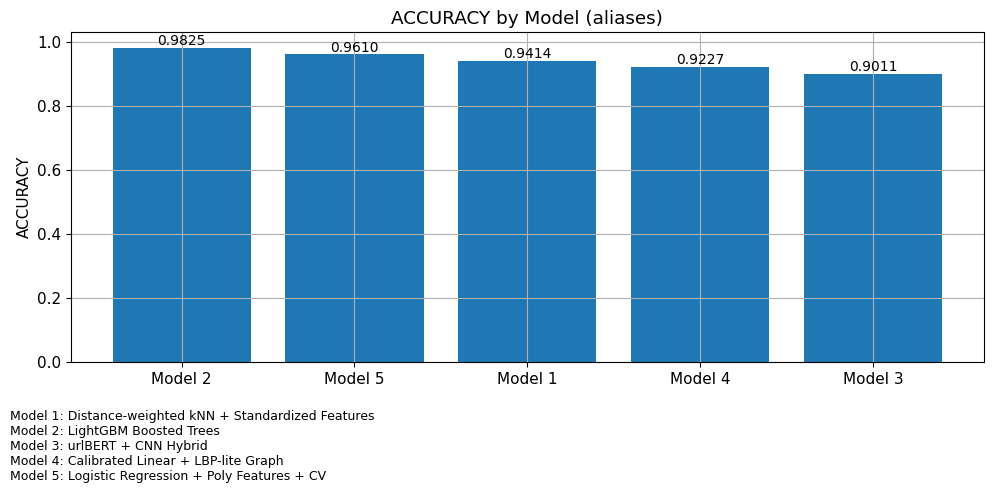

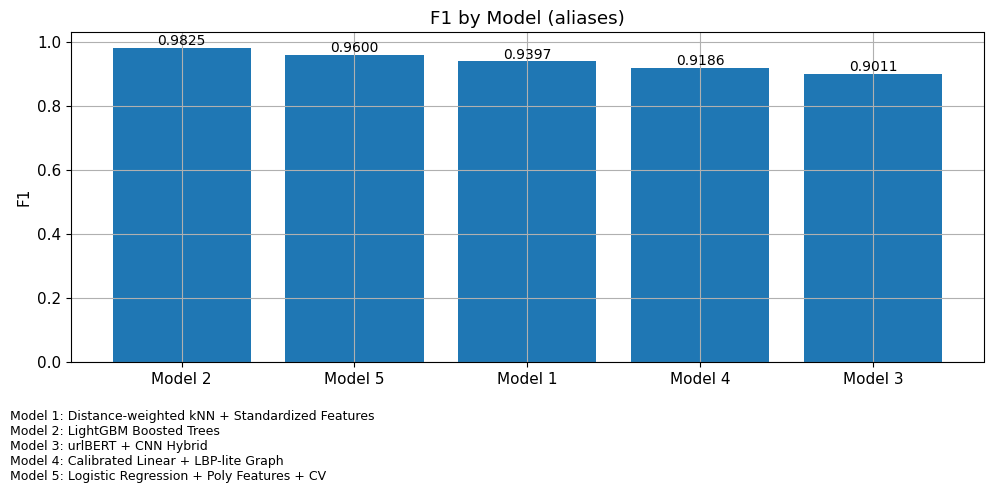

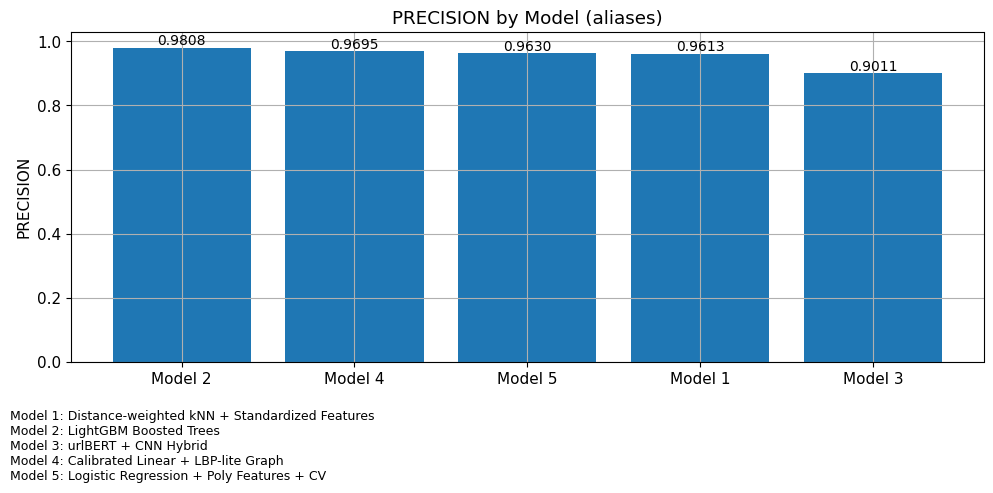

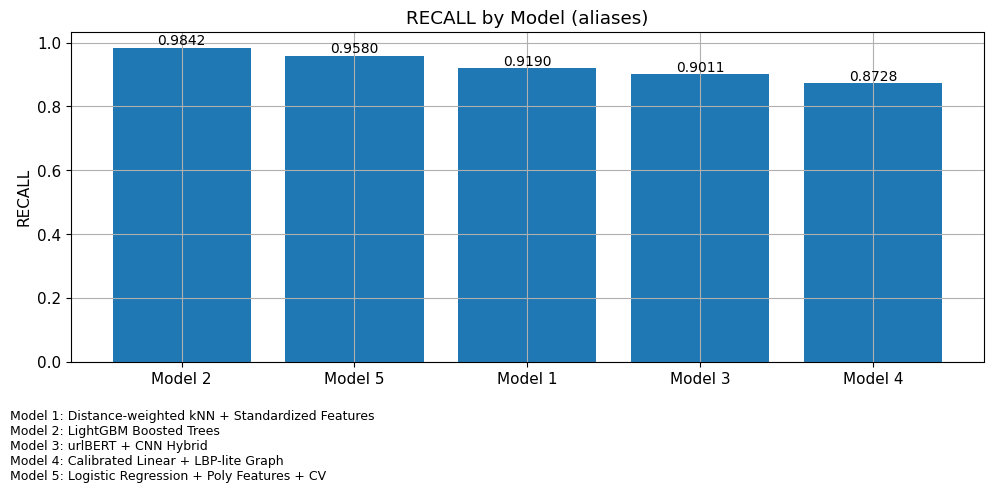

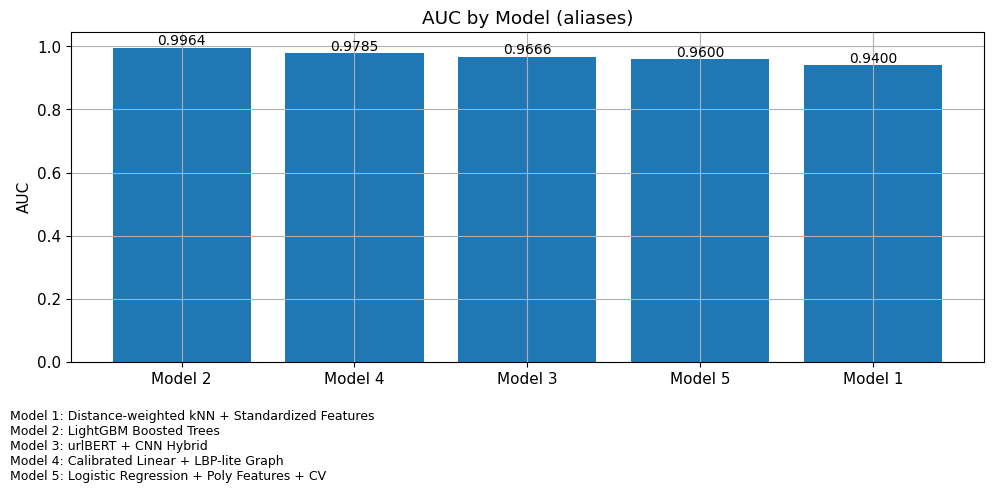

In [ ]:
# =========================================================
# SECTION 6 — Clear bar plots using aliases + on-plot remarks
# =========================================================
def bar_plot(metric: str):
    col = f"{metric}_mean"
    if col not in summary.columns:
        return
    # Sort by the metric for plotting
    order = summary.sort_values(col, ascending=False).reset_index(drop=True)

    labels = order["alias"].tolist()               # Model 1, Model 2, ...
    values = order[col].values

    # Mapping text (remarks) to print inside the figure
    mapping_lines = [f"{alias_map[n]}: {n}" for n in seen]
    mapping_text = "\n".join(mapping_lines)

    plt.figure()
    bars = plt.bar(labels, values)
    plt.title(f"{metric.upper()} by Model (aliases)")
    plt.ylabel(metric.upper())
    plt.xticks(rotation=0, ha="center")

    # annotate exact values
    for b, v in zip(bars, values):
        plt.text(b.get_x() + b.get_width()/2, b.get_height(),
                 f"{v:.4f}", ha="center", va="bottom", fontsize=10)

    # leave bottom margin for remarks and print them
    plt.tight_layout(rect=(0, 0.18, 1, 1))  # make space at bottom
    plt.figtext(0.01, 0.02, mapping_text, ha="left", va="bottom", fontsize=9)
    plt.show()

for m in ["accuracy","f1","precision","recall","auc"]:
    bar_plot(m)